# 创建客户细分 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import scale
from sklearn.svm import OneClassSVM
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score # K-mean 聚类轮廓系数，这个值范围在-1（不相似）到1（相似）

%matplotlib inline

In [2]:
data = pd.read_csv('customers.csv')
data.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [3]:
data = data.drop(['Region', 'Channel'], axis=1)
data.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,12669,9656,7561,214,2674,1338
1,7057,9810,9568,1762,3293,1776
2,6353,8808,7684,2405,3516,7844
3,13265,1196,4221,6404,507,1788
4,22615,5410,7198,3915,1777,5185


In [4]:
data.describe()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


观察特征之间的相关性

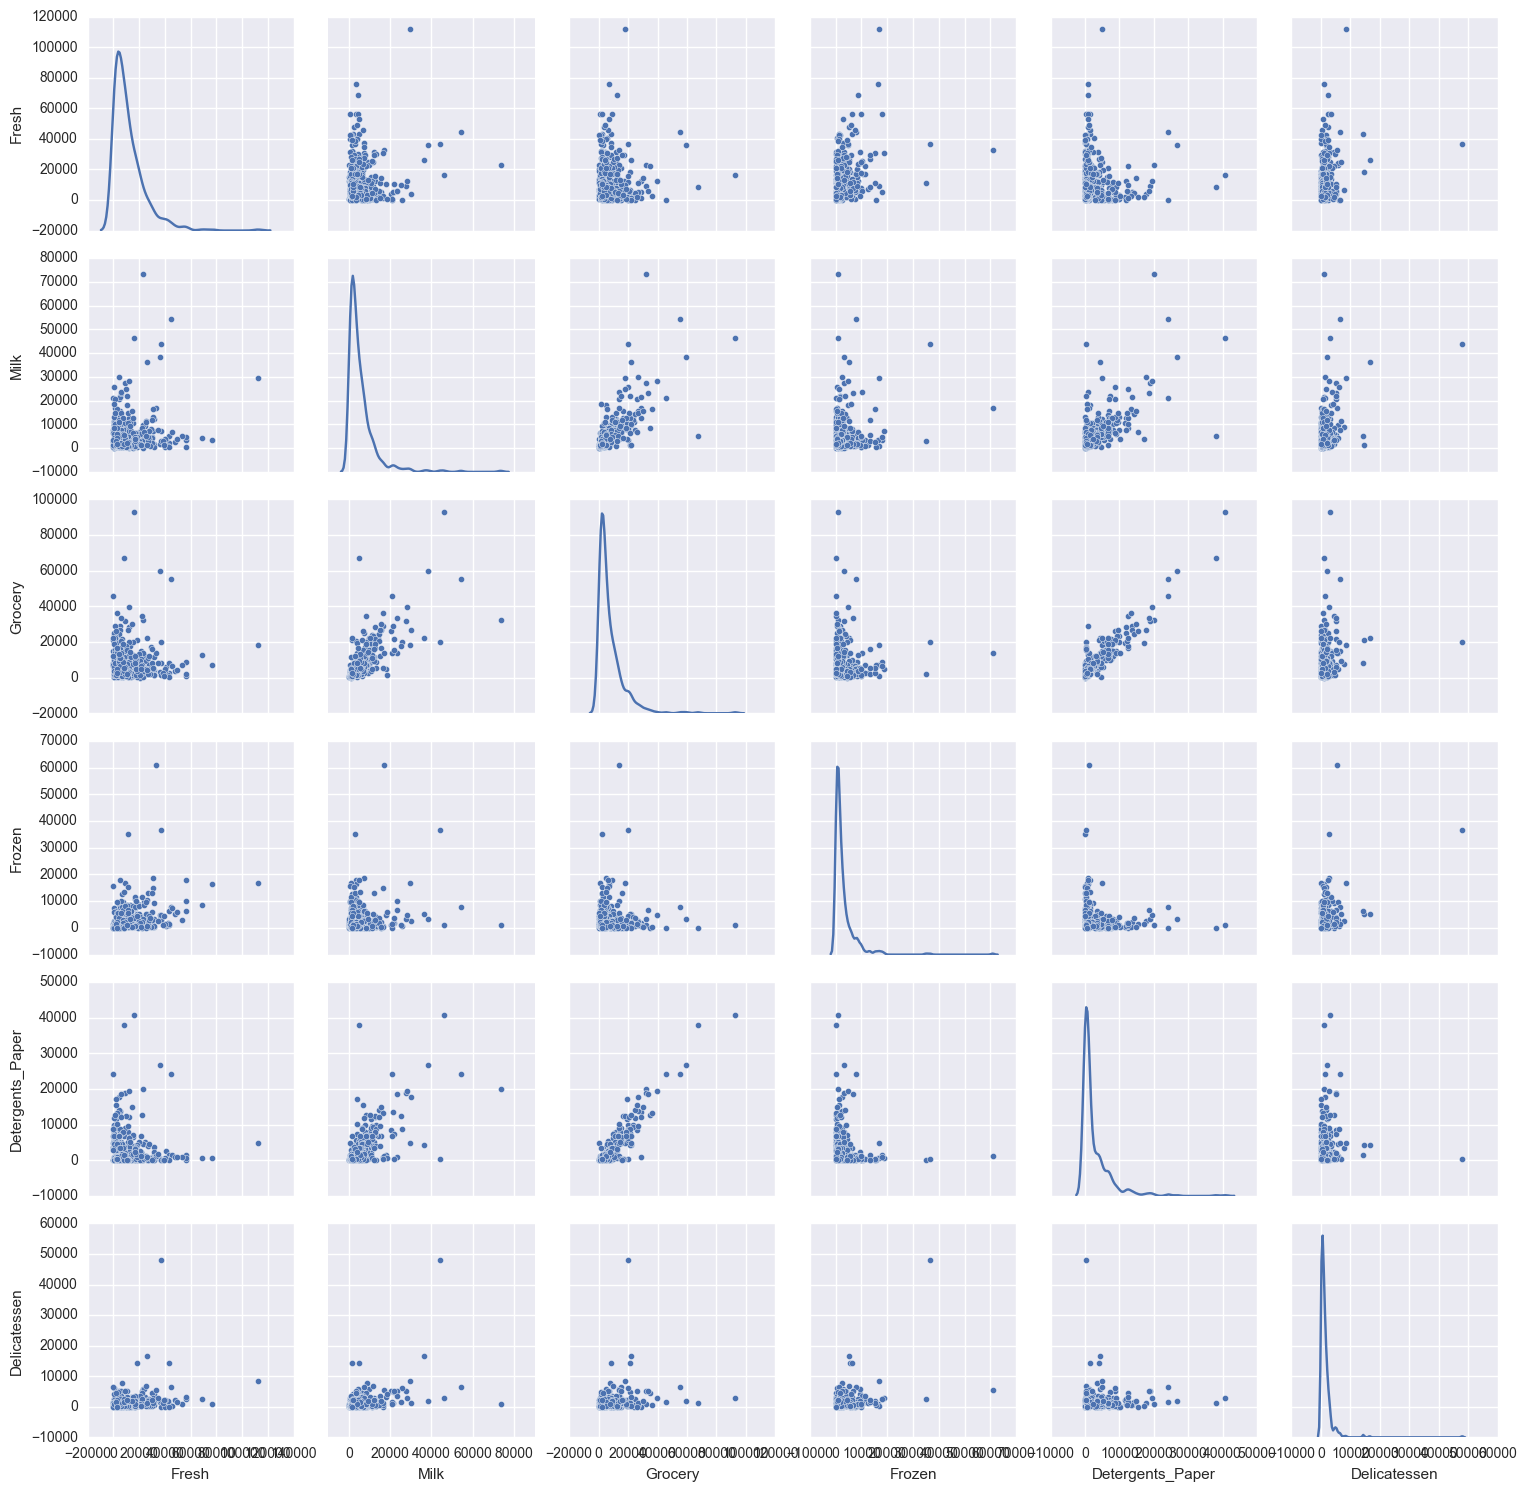

In [5]:
sns.pairplot(data, diag_kind='kde');

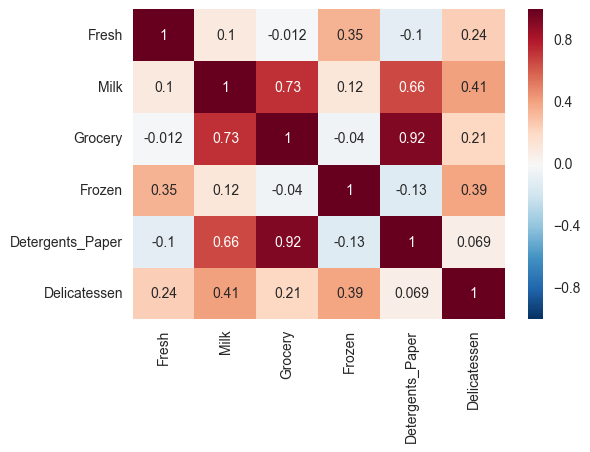

In [6]:
sns.heatmap(data.corr(), annot=True)

从上图中可以看出，有几个特征之间的相关性是挺大的

### 数据预处理

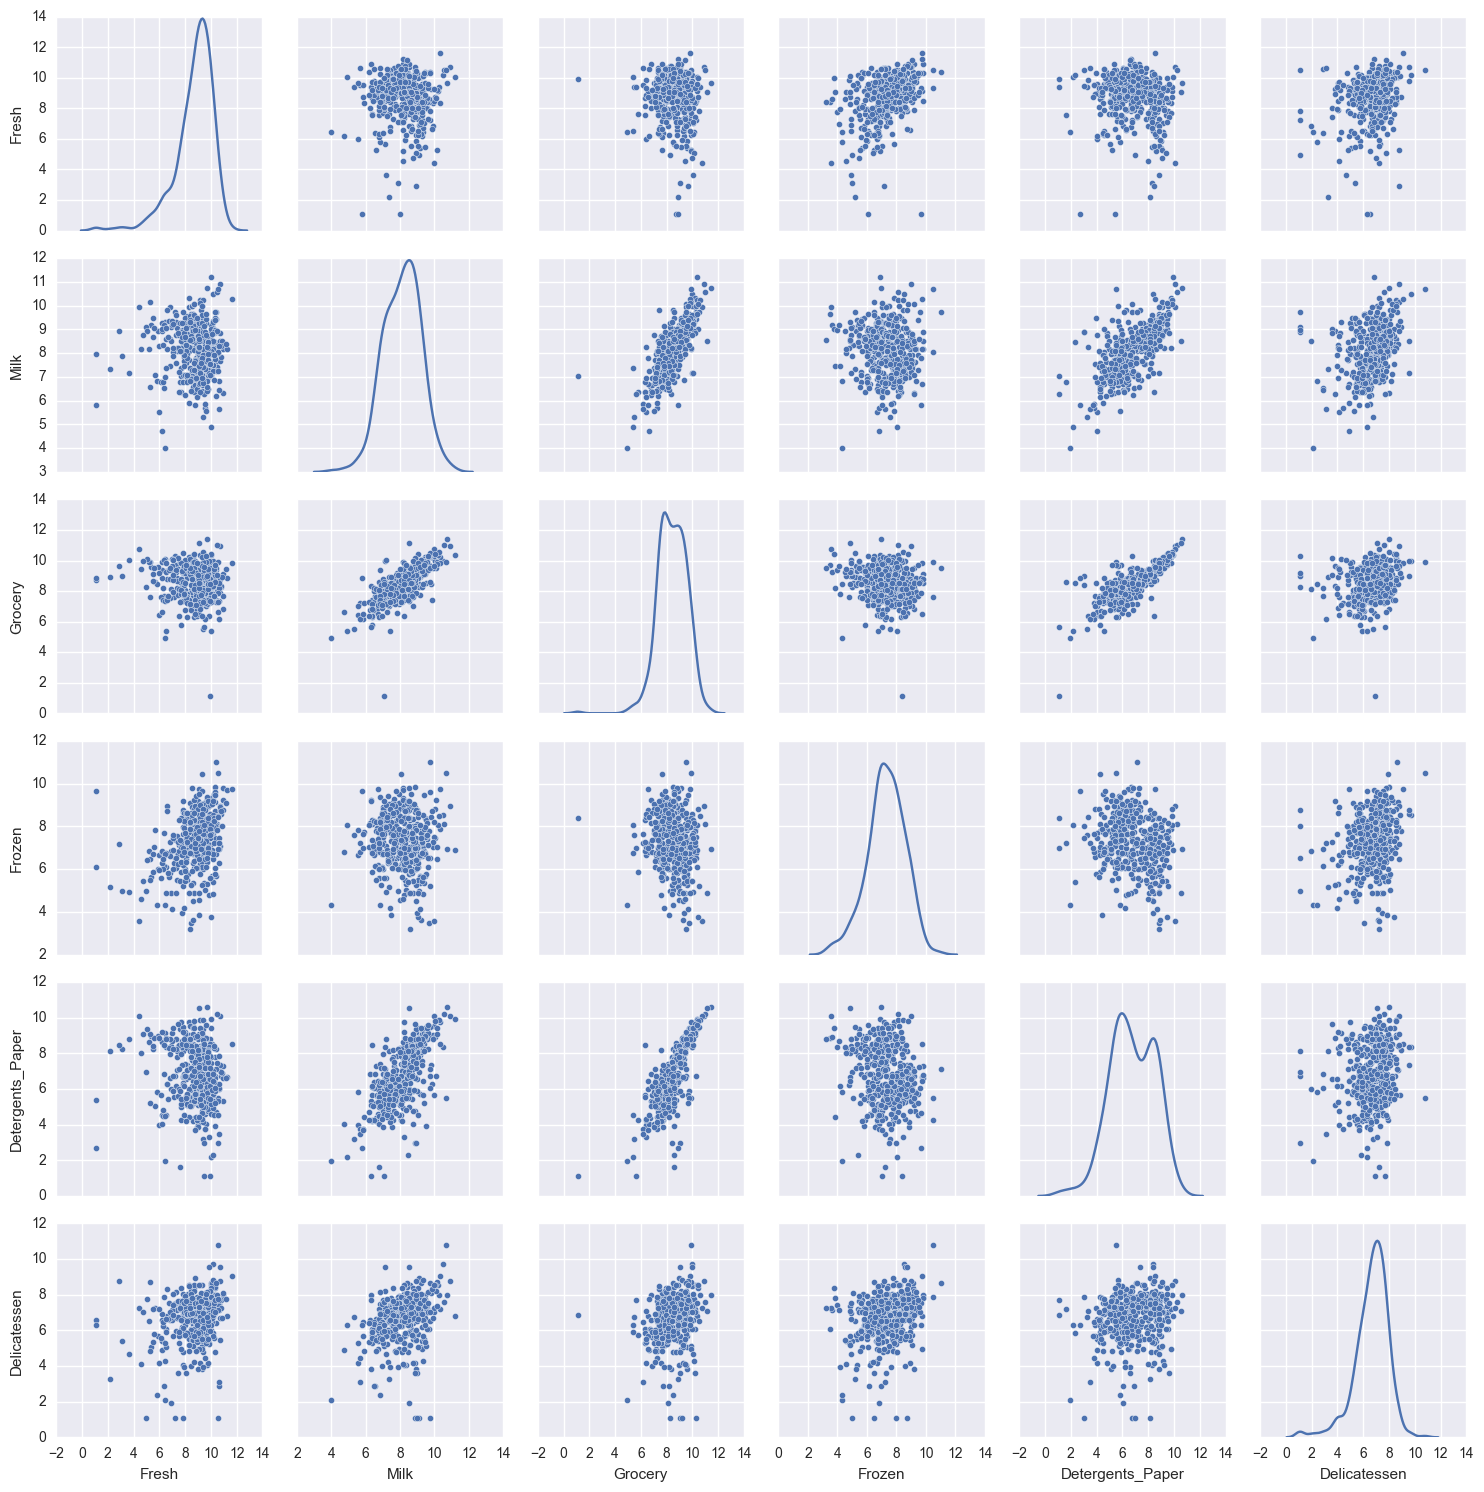

In [7]:
# 取自然对数
log_data = np.log(data)
sns.pairplot(log_data, diag_kind='kde');

In [8]:
# # 去均值,方差归一
# scale_log_data = scale(log_data)
# scale_log_data = pd.DataFrame(scale_log_data)
# sns.pairplot(scale_log_data, diag_kind='kde');

In [9]:
# 去除异常值
scale_log_data = log_data
clf = OneClassSVM(nu=0.2)
clf.fit(scale_log_data)
X = clf.predict(scale_log_data)
X.shape

(440,)

In [10]:
np.sum(X==1)

352

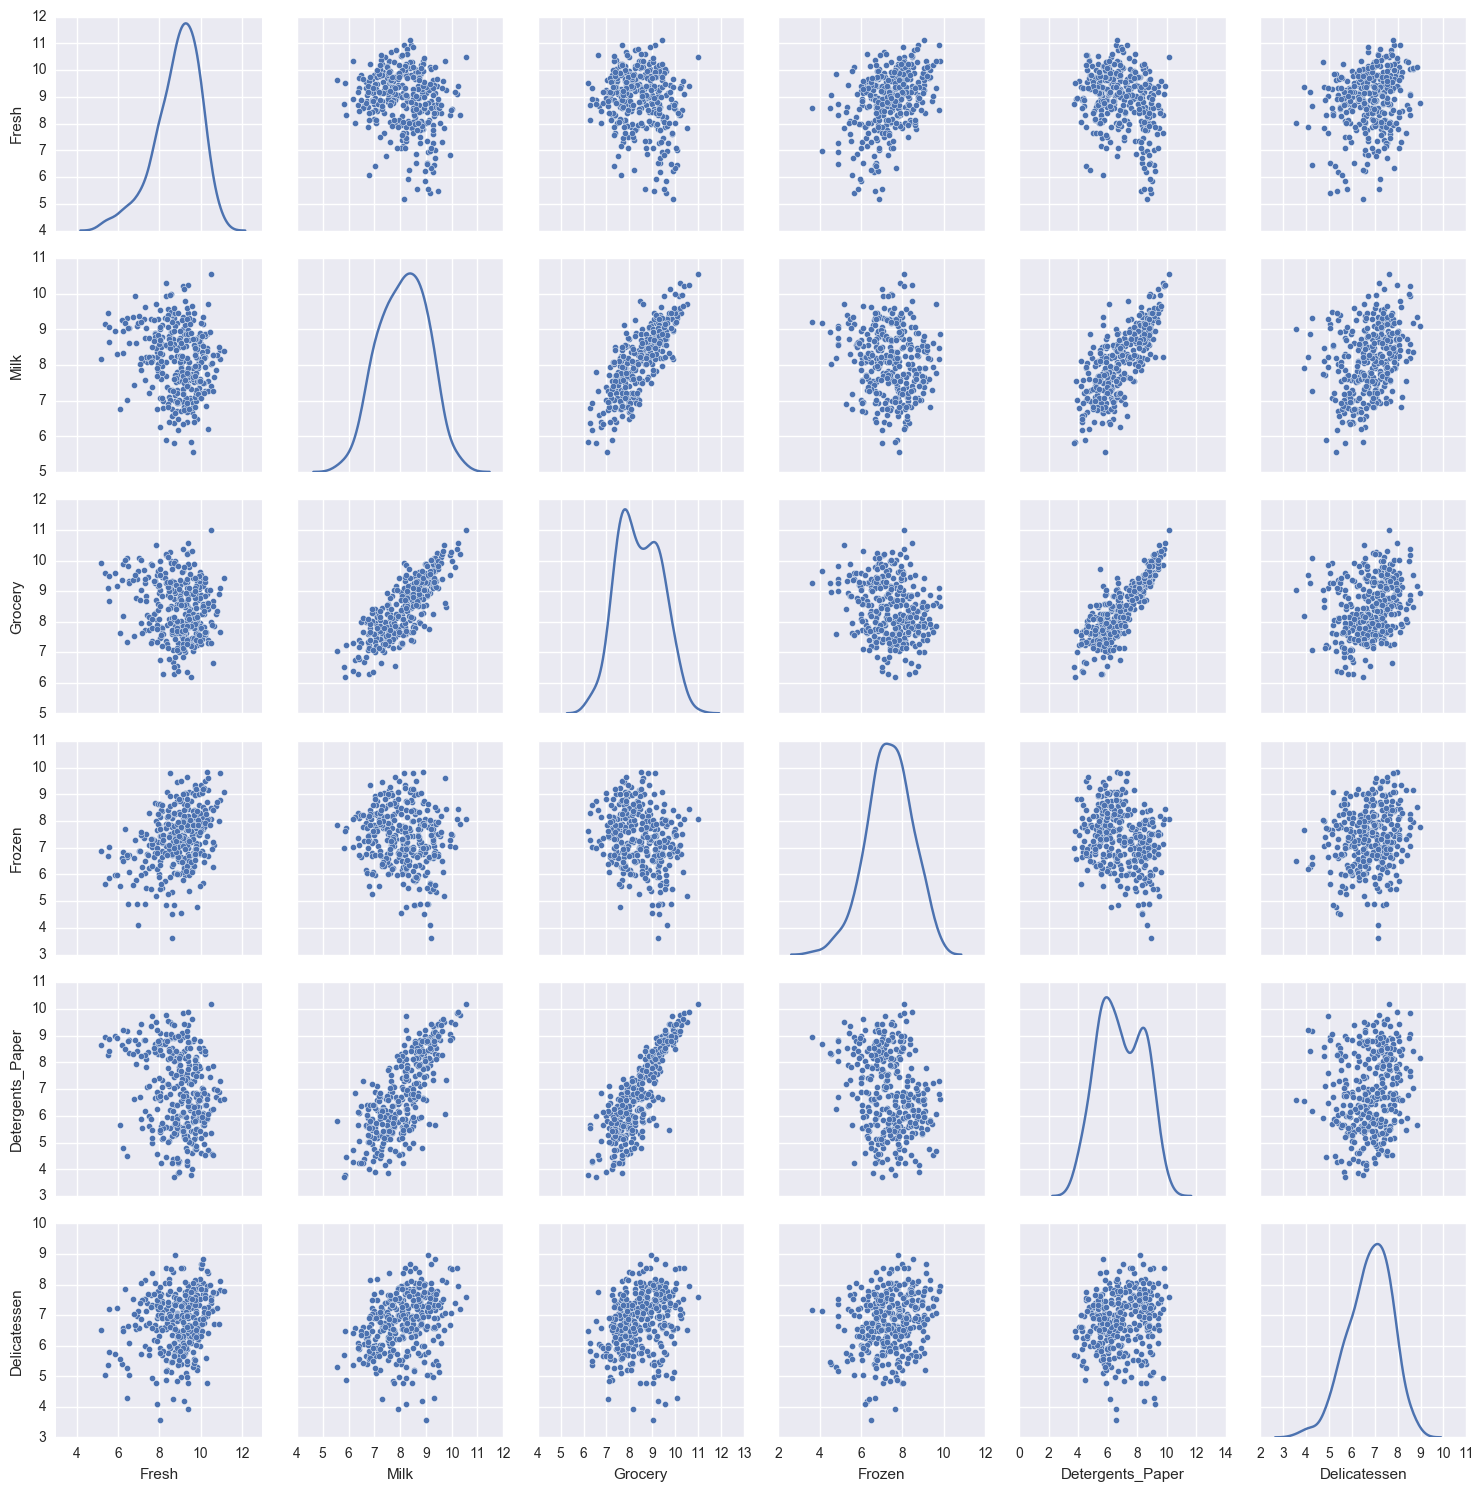

In [11]:
pos = np.where(X == 1)
sns.pairplot(scale_log_data.loc[pos], diag_kind='kde')

In [12]:
# 赋值为good_data
good_data = scale_log_data.loc[pos]
print good_data.shape
good_data.head()

(352, 6)


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,9.446913,9.175335,8.930759,5.365976,7.891331,7.198931
1,8.861775,9.191158,9.166179,7.474205,8.099554,7.482119
2,8.756682,9.083416,8.946896,7.785305,8.165079,8.967504
3,9.492884,7.086738,8.347827,8.764678,6.228511,7.488853
4,10.026369,8.596004,8.881558,8.272571,7.482682,8.553525


In [13]:
# PCA 主成分分析
pca = PCA(n_components='mle').fit(good_data)
pca.n_components_ # 自动选择了5维

5

In [14]:
pca_good_data = pca.transform(good_data)
print pca_good_data.shape
pca_good_data = pd.DataFrame(pca_good_data)
pca_good_data.head()

(352, 5)


,0,1,2,3,4
0,1.723668,-0.281750,-1.693906,-0.813486,-0.371504
1,1.683724,0.818282,0.126827,-0.222260,-0.168930
2,1.686403,1.596616,0.572739,-1.323736,0.409359
3,-1.321422,1.236418,0.512398,-0.020103,0.666937
4,0.523369,2.267887,-0.082874,-0.704757,0.289040


新数据pca_good_data已经映射到新的向量空间上了

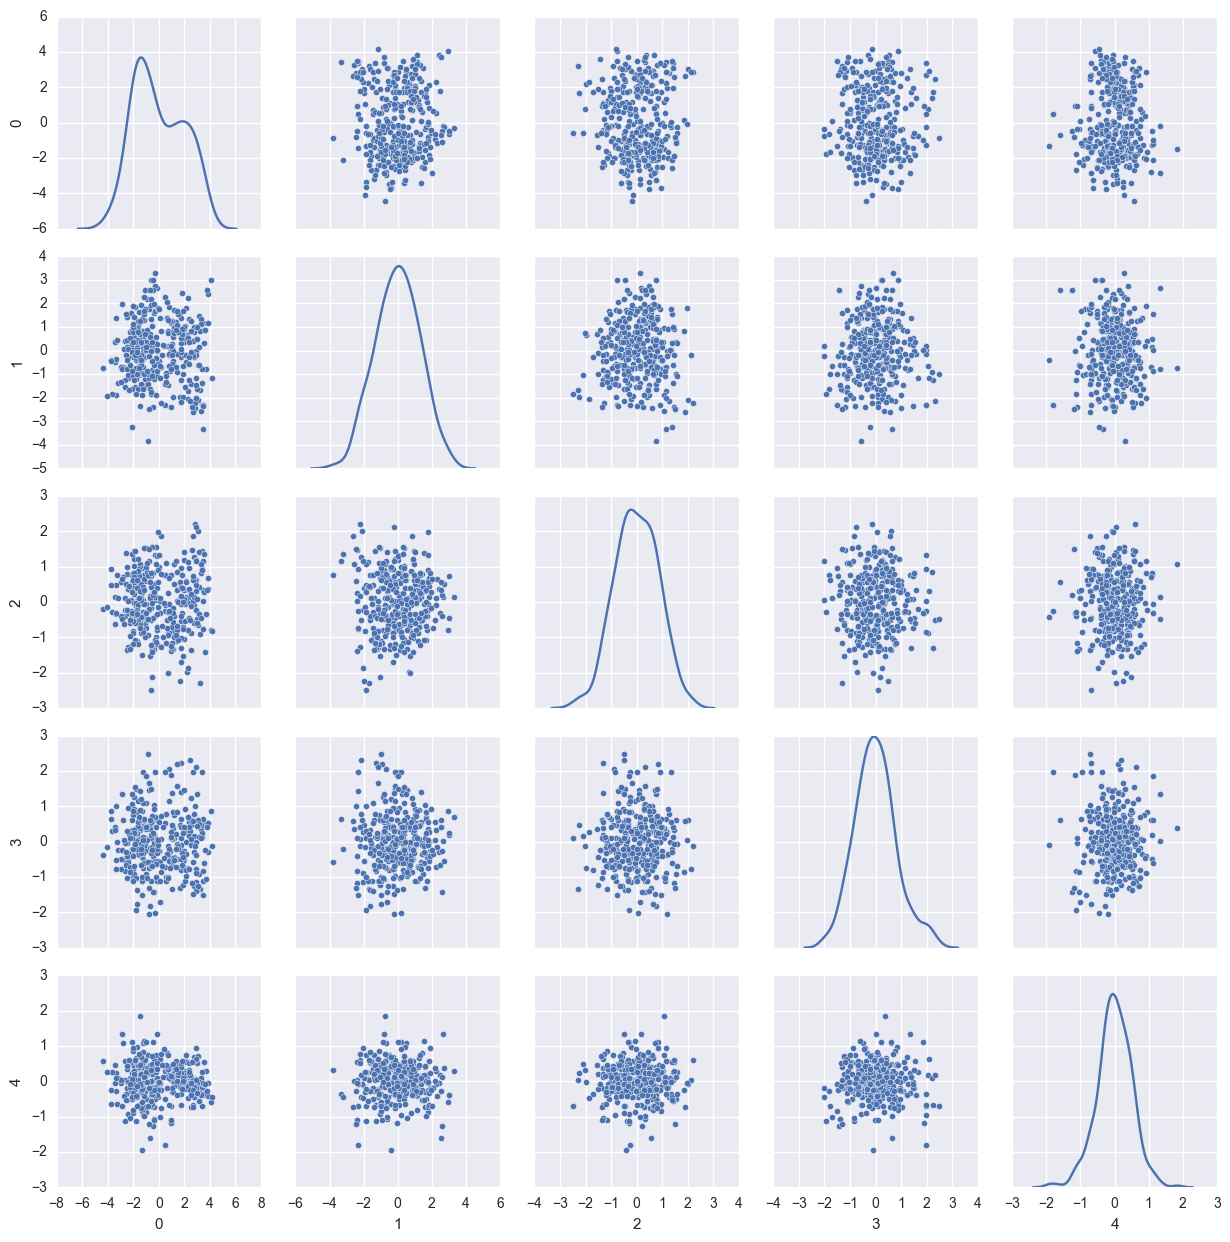

In [15]:
sns.pairplot(pca_good_data, diag_kind='kde');

经过降维之后的数据，就没有那两个特征还有点关系了，都成高斯形

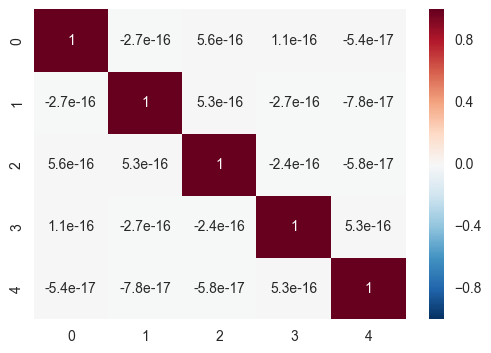

In [16]:
sns.heatmap(pca_good_data.corr(), annot=True)

### 数据预处理结束

## 使用K-mean对用户进行聚类达到客户细分 

In [17]:
cluster = KMeans(n_clusters=2)
cluster.fit(pca_good_data)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=2, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

In [18]:
preds = cluster.predict(pca_good_data)
preds.shape

(352,)

In [19]:
silhouette_score(pca_good_data, preds)

0.35954849614863843

In [20]:
type1 = np.where(preds == 1)
type2 = np.where(preds == 0)
type1 = type1[0]
type2 = type2[0]

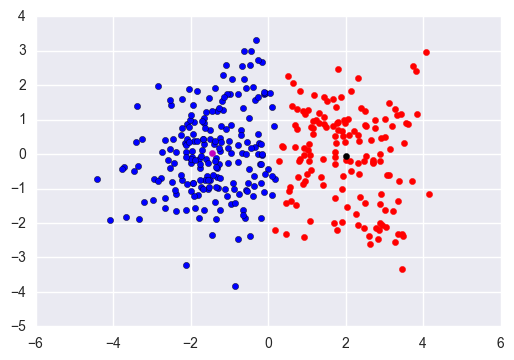

In [21]:
plt.scatter(pca_good_data.loc[type1][0], pca_good_data.loc[type1][1])
plt.scatter(pca_good_data.loc[type2][0], pca_good_data.loc[type2][1], color = 'r')
plt.scatter(cluster.cluster_centers_[0, 0], cluster.cluster_centers_[0, 1], color = 'k')
plt.scatter(cluster.cluster_centers_[1, 0], cluster.cluster_centers_[1, 1], color = 'm', marker='o')
plt.show()

In [22]:
log_centers = pca.inverse_transform(cluster.cluster_centers_)
log_centers.shape

(2, 6)

In [26]:
true_centers = np.exp(log_centers)
true_centers = pd.DataFrame(true_centers, columns=data.keys())
true_centers

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,4686.450620,7272.805188,10875.908790,944.089411,4424.376231,1023.220733
1,9869.670428,1950.541860,2486.228191,2329.590758,334.151988,795.932144


In [27]:
true_centers = true_centers.append(data.describe().loc['mean'])
true_centers

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,4686.450620,7272.805188,10875.908790,944.089411,4424.376231,1023.220733
1,9869.670428,1950.541860,2486.228191,2329.590758,334.151988,795.932144
mean,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455


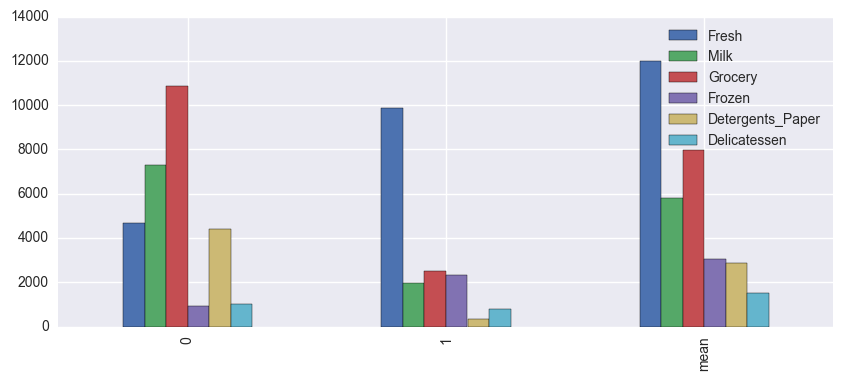

In [31]:
true_centers.plot(kind='bar', figsize=(10, 4))